<a href="https://colab.research.google.com/github/Abhishikth3330/web-app-crack-detection/blob/main/Image_Denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## setup and imports

In [5]:
# Imports PyTorch, the core deep-learning library.
import torch
# Imports the neural network module of PyTorch.
# it has ready made components - {nn.Conv2d, nn.ReLU, nn.Sequential}
import torch.nn as nn
# Imports optimization algorithms. - {Adam, SGD}
import torch.optim as optim

# Provides datasets and utilities specifically for computer vision.
# instead of collecting images naturally we can use datasets
# CIFAR10, MNIST, ImageNet
import torchvision

# Imports image preprocessing utilities.
# Neural networks cannot read raw images — they must be converted into tensors and normalized.
# clean image (X) --> add noise (N) --> train model to recover (X) from (X+N)
import torchvision.transforms as transforms

# Imports plotting library for visualization.
import matplotlib.pyplot as plt

In [6]:
# check if colab has given us a GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device : {device}")

Using device : cuda


## data preparation (Noise factory)

In [10]:
# defining our own dataset class.
# CIFAR-10 gives clean images, but denoising requires training
# y = x + v
# x = clean image
# v = noise
# y = noisy image (input to model)
class NoisyDataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset, noise_level = 25.0/255.0):
        # original clean dataset (CIFAR-10 here)
        self.base_dataset = base_dataset
        # how strong the Gaussian noise is.
        self.noise_level = noise_level

    # Returns number of samples.
    # We are not adding new images, only corrupting existing ones.
    def __len__(self):
        return len(self.base_dataset)

    # Generating Noise
    def __getitem__(self, idx):
        # we grab a clean image. we don't care about the classification label (_)
        clean_img, _ = self.base_dataset[idx]

        # generate random gaussian noise of the exact same size
        noise = torch.randn(clean_img.size()) * self.noise_level

        # create the noisy image (y = x + v)
        noisy_img = clean_img + noise

        # crucial step : the DnCNN predicts the RESIDUAL (the noise)
        # so our target label for the network isn't the clean image, it's the noise
        return noisy_img, noise

## Load CIFAR-10 (Clean Data Source)

In [11]:
# download and format CIFAR10
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

In [12]:
# wrap it in our noise generator and load it into batches
noisy_trainset = NoisyDataset(trainset)
trainloader = torch.utils.data.DataLoader(noisy_trainset, batch_size=128, shuffle=True)

## Defining the DnCNN Model

In [14]:
# nn.Module
# Every learnable model in PyTorch must inherit from this so it can:
# Store weights
# Track gradients
# Move to GPU
# Be optimized
class DnCNN(nn.Module):
    # depth=17 -> Number of convolution layers -> Deep enough to learn noise patterns
    # n_channels=3 -> RGB input -> CIFAR10 is color
    # n_filters=64 -> Feature maps per layer -> Standard capacity
    # kernel_size=3 -> 3×3 convolutions -> Best tradeoff for vision tasks
    def __init__(self, depth=17, n_channels=3, n_filters=64, kernel_size=3):
        super(DnCNN, self).__init__()


        # layer 1
        layers = [
            nn.Conv2d(in_channels=n_channels,
                      out_channels=n_filters,
                      kernel_size=kernel_size,
                      padding=1,
                      bias=False),
            nn.ReLU(inplace=True)
        ]


        # layers 2 to 16
        for _ in range(depth - 2):
            layers.append(nn.Conv2d(in_channels=n_filters,
                                    out_channels=n_filters,
                                    kernel_size=kernel_size,
                                    padding=1,
                                    bias=False))
            layers.append(nn.BatchNorm2d(n_filters))
            layers.append(nn.ReLU(inplace=True))

        # layer 17
        layers.append(nn.Conv2d(in_channels=n_filters,
                                out_channels=n_channels,
                                kernel_size=kernel_size,
                                padding=1,
                                bias=False))

        self.dncnn = nn.Sequential(*layers)


    def forward(self, x):
        return self.dncnn(x)

# Initialize the model and send it to the GPU.
# We use n_channels=3 because CIFAR10 images are in color.
model = DnCNN(n_channels=3).to(device)

## The Training Loop

In [15]:
# Defines the Mean Squared Error (MSE) loss.
# We use 'sum' to manually average it later
criterion = nn.MSELoss(reduction='sum')

# Uses the Adam optimizer to update network weights.
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 5

print("Starting Training Loop...")

for epoch in range(epochs):
    running_loss = 0.0
    model.train()

    for i, data in enumerate(trainloader, 0):
        noisy_imgs, target_noise = data
        noisy_imgs, target_noise = noisy_imgs.to(device), target_noise.to(device)

        optimizer.zero_grad()

        # forward pass: predict the noise map
        predicted_noise = model(noisy_imgs)

        # calculate loss according to the DnCNN paper standards
        loss = criterion(predicted_noise, target_noise) / (noisy_imgs.size(0) * 2)

        # backward pass and upadte weights
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # print every 100 mini-batches
        if i % 100 == 99:
            print(f"[Epoch {epoch + 1}, Batch {i + 1}] Loss : {running_loss / 100:.4f}")
            running_loss = 0.0

print("Training Complete! The model is ready.")


Starting Training Loop...
[Epoch 1, Batch 100] Loss : 28.8014
[Epoch 1, Batch 200] Loss : 14.8227
[Epoch 1, Batch 300] Loss : 14.7951
[Epoch 2, Batch 100] Loss : 14.7798
[Epoch 2, Batch 200] Loss : 14.7744
[Epoch 2, Batch 300] Loss : 14.7707
[Epoch 3, Batch 100] Loss : 13.6983
[Epoch 3, Batch 200] Loss : 10.0626
[Epoch 3, Batch 300] Loss : 7.1550
[Epoch 4, Batch 100] Loss : 4.8026
[Epoch 4, Batch 200] Loss : 4.2417
[Epoch 4, Batch 300] Loss : 3.9667
[Epoch 5, Batch 100] Loss : 3.5874
[Epoch 5, Batch 200] Loss : 3.4890
[Epoch 5, Batch 300] Loss : 3.4162
Training Complete! The model is ready.


In [16]:
import math
import numpy as np

# 1. Define the PSNR mathematical formula
def calculate_psnr(img1, img2, max_val=1.0):
    mse = torch.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * math.log10(max_val / math.sqrt(mse.item()))

# 2. Put the model in "Evaluation Mode" (locks the weights)
model.eval()

# 3. Grab a single batch of data from our dataset
dataiter = iter(trainloader)
noisy_imgs, target_noise = next(dataiter)

# Move to GPU
noisy_imgs = noisy_imgs.to(device)
target_noise = target_noise.to(device)

# 4. Forward Pass: Get the model's prediction
# We use torch.no_grad() because we don't need to train/update weights here
with torch.no_grad():
    predicted_noise = model(noisy_imgs)

# 5. The Magic Step: Subtract the predicted noise from the noisy input
denoised_imgs = noisy_imgs - predicted_noise

# 6. Calculate the score
# We isolate the very first image in the batch for our test
clean_img = noisy_imgs[0] - target_noise[0]
psnr_score = calculate_psnr(clean_img, denoised_imgs[0])

print(f"Academic PSNR Score: {psnr_score:.2f} dB")

Academic PSNR Score: 26.40 dB


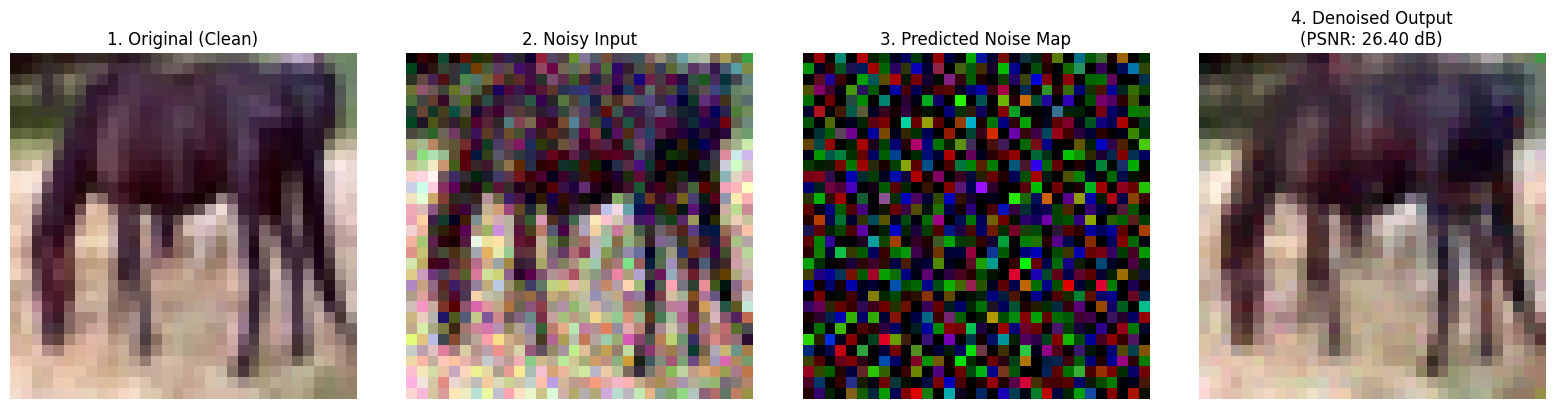

In [17]:
# Helper function to convert PyTorch Tensors back to images
def tensor_to_img(tensor):
    img = tensor.cpu().numpy()
    # PyTorch uses (Channel, Height, Width), Matplotlib wants (Height, Width, Channel)
    img = np.transpose(img, (1, 2, 0))
    img = np.clip(img, 0, 1) # Ensure pixel values don't break the display
    return img

plt.figure(figsize=(16, 4))

plt.subplot(1, 4, 1)
plt.title("1. Original (Clean)")
plt.imshow(tensor_to_img(clean_img))
plt.axis('off')

plt.subplot(1, 4, 2)
plt.title("2. Noisy Input")
plt.imshow(tensor_to_img(noisy_imgs[0]))
plt.axis('off')

plt.subplot(1, 4, 3)
plt.title("3. Predicted Noise Map")
# Normalize the noise tensor just so we can see the pattern visually
noise_vis = tensor_to_img(predicted_noise[0])
noise_vis = (noise_vis - noise_vis.min()) / (noise_vis.max() - noise_vis.min() + 1e-5)
plt.imshow(noise_vis)
plt.axis('off')

plt.subplot(1, 4, 4)
plt.title(f"4. Denoised Output\n(PSNR: {psnr_score:.2f} dB)")
plt.imshow(tensor_to_img(denoised_imgs[0]))
plt.axis('off')

plt.tight_layout()
plt.show()